In [1]:
# Imports 
import pandas as pd
from datetime import datetime
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy import stats


#for LDA:
import gzip
import tarfile
import xml.etree.ElementTree as ET
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

In [2]:
# function that extracts the meaningful words in each XML file
def parse_corenlp_file(file):
    with gzip.open(file, 'rt', encoding='utf-8') as f:
        tree = ET.parse(f)
        root = tree.getroot()
        filtered_words = []
        for token in root.iter('token'):
            lemma = token.find('lemma').text
            pos = token.find('POS').text
            if pos in {'NN', 'NNS'} or pos.startswith('VB') or pos.startswith('JJ'):
                filtered_words.append(lemma)
        return ' '.join(filtered_words)

In [3]:
#os.chdir(os.path.join(os.getcwd(), "..", ".."))

tar_path = 'data/corenlp_plot_summaries.tar'

documents = []
ids = []

with tarfile.open(tar_path, 'r') as tar:
    for member in tar.getmembers():
        if member.name.endswith('.xml.gz'):
            with tar.extractfile(member) as xml_gz_file:
                film_id = member.name.split('/')[-1].replace('.xml.gz', '')
                ids.append(film_id)
                document = parse_corenlp_file(xml_gz_file)
                documents.append(document)

In [18]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
# tokenized_documents = [doc.lower().split() for doc in documents]
tokenized_documents = [[word for word in doc.lower().split() if len(word) >= 2] for doc in documents]
dictionary = Dictionary(tokenized_documents)

import random
seed = 42
random.seed(seed)
np.random.seed(seed)
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 20220
Number of chunks: 42306


In [19]:
for idx, topic in model.print_topics(num_words=5):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.022*"ship" + 0.013*"island" + 0.013*"boat" + 0.011*"crew" + 0.008*"take"
Topic 1: 0.011*"get" + 0.008*"go" + 0.008*"find" + 0.007*"see" + 0.007*"dog"
Topic 2: 0.009*"young" + 0.009*"life" + 0.008*"man" + 0.008*"family" + 0.007*"woman"
Topic 3: 0.047*"film" + 0.011*"movie" + 0.011*"story" + 0.007*"character" + 0.006*"scene"
Topic 4: 0.014*"find" + 0.012*"kill" + 0.010*"house" + 0.010*"go" + 0.009*"see"
Topic 5: 0.020*"school" + 0.011*"student" + 0.010*"friend" + 0.010*"win" + 0.009*"team"
Topic 6: 0.016*"police" + 0.016*"kill" + 0.010*"find" + 0.010*"murder" + 0.010*"man"
Topic 7: 0.014*"father" + 0.014*"love" + 0.013*"family" + 0.012*"get" + 0.011*"marry"
Topic 8: 0.018*"tell" + 0.018*"go" + 0.014*"get" + 0.013*"do" + 0.011*"leave"
Topic 9: 0.015*"kill" + 0.010*"man" + 0.009*"take" + 0.008*"attack" + 0.008*"soldier"
Topic 10: 0.010*"film" + 0.009*"show" + 0.007*"become" + 0.007*"life" + 0.006*"play"
Topic 11: 0.010*"use" + 0.007*"destroy" + 0.006*"find" + 0.006*"kill" + 0.00

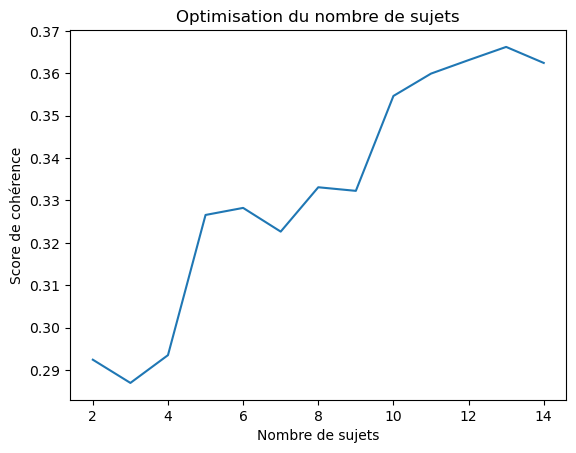

Nombre optimal de sujets : 13
Topic 0: 0.012*"friend" + 0.012*"school" + 0.010*"get" + 0.009*"go" + 0.009*"love" + 0.008*"girl" + 0.008*"do" + 0.008*"make" + 0.007*"become" + 0.007*"show"
Topic 1: 0.010*"dog" + 0.009*"get" + 0.008*"see" + 0.007*"go" + 0.007*"run" + 0.007*"try" + 0.007*"cat" + 0.006*"find" + 0.006*"water" + 0.006*"head"
Topic 2: 0.011*"man" + 0.009*"soldier" + 0.009*"war" + 0.008*"take" + 0.007*"ship" + 0.007*"order" + 0.006*"german" + 0.006*"kill" + 0.006*"return" + 0.006*"british"
Topic 3: 0.018*"love" + 0.018*"father" + 0.016*"get" + 0.016*"marry" + 0.015*"family" + 0.012*"go" + 0.012*"do" + 0.011*"son" + 0.010*"take" + 0.010*"come"
Topic 4: 0.015*"kill" + 0.009*"use" + 0.009*"attack" + 0.009*"find" + 0.007*"escape" + 0.007*"destroy" + 0.007*"take" + 0.006*"fight" + 0.005*"other" + 0.005*"power"
Topic 5: 0.020*"kill" + 0.018*"police" + 0.011*"man" + 0.010*"gang" + 0.010*"take" + 0.009*"murder" + 0.009*"find" + 0.009*"shoot" + 0.008*"get" + 0.008*"escape"
Topic 6: 0.0

In [13]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary


# Fonction pour entraîner un modèle LDA et calculer la cohérence
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Fonction pour trouver la cohérence du modèle pour différents nombres de sujets.
    
    Args:
        dictionary: Le dictionnaire Gensim
        corpus: Le corpus BoW
        texts: Les documents tokenisés
        start: Nombre minimum de sujets
        limit: Nombre maximum de sujets
        step: Incrémentation pour le nombre de sujets
    
    Returns:
        model_list: Liste des modèles LDA entraînés
        coherence_values: Liste des scores de cohérence pour chaque modèle
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(
            corpus=corpus,
            num_topics=num_topics,
            id2word=dictionary,
            passes=10,
            workers=4,
            random_state=42,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Étape 2 : Définir les paramètres pour l'optimisation
start = 2  # Nombre minimum de sujets
limit = 10  # Nombre maximum de sujets
step = 1  # Pas entre chaque essai de nombre de sujets

# Étape 3 : Calculer les cohérences pour différents nombres de sujets
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary, corpus=corpus, texts=tokenized_documents, start=start, limit=limit, step=step
)

# Étape 4 : Visualiser les résultats
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Nombre de sujets")
plt.ylabel("Score de cohérence")
plt.title("Optimisation du nombre de sujets")
plt.show()

# Étape 5 : Sélectionner le meilleur modèle (celui avec le score de cohérence maximal)
best_num_topics = x[coherence_values.index(max(coherence_values))]
best_model = model_list[coherence_values.index(max(coherence_values))]

print(f"Nombre optimal de sujets : {best_num_topics}")

# Afficher les sujets du meilleur modèle
for idx, topic in best_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Calculer l'importance (pondération) des sujets dans le corpus
topic_importance = [0] * best_model.num_topics

for doc in corpus:
    doc_topics = best_model.get_document_topics(doc, minimum_probability=0)
    for topic_id, prob in doc_topics:
        topic_importance[topic_id] += prob

# Trier les sujets par importance
sorted_topics = sorted(enumerate(topic_importance), key=lambda x: x[1], reverse=True)

# Afficher les sujets triés
print("Sujets triés par importance :")
for topic_id, importance in sorted_topics:
    print(f"Topic {topic_id} (importance globale : {importance:.4f}):")
    print(best_model.print_topic(topic_id, topn=10))

travailler sur un compromis coherence/generalisation ==> oui ok increase # topics ==> increase coherence mais ca decrease la generalisation/interpretabilités ==> elbow methode pour la ou le gain en coherence est réduit

In [11]:
# Vectorization for LDA
vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(documents)

# LDA
lda = LatentDirichletAllocation(n_components=6,random_state=42) # random seed for reproducibility
lda.fit(doc_term_matrix)
doc_topic_dist = lda.transform(doc_term_matrix)

In [12]:
top_themes_per_document = []
for i, doc in enumerate(doc_topic_dist):
    top_indices = doc.argsort()[-3:][::-1] # Indices of the top 3 values in the array doc, sorted in descending order. 
    top_proportions = doc[top_indices]

    top_themes_per_document.append({
        "Wikipedia movie ID": ids[i],
        "Theme 1": top_indices[0],
        "Prop Theme 1": top_proportions[0],
        "Theme 2": top_indices[1],
        "Prop Theme 2": top_proportions[1],
        "Theme 3": top_indices[2],
        "Prop Theme 3": top_proportions[2]
    })

df_top_themes = pd.DataFrame(top_themes_per_document)


df_date_clean['Wikipedia movie ID'] = df_date_clean['Wikipedia movie ID'].astype(str)
df_top_themes['Wikipedia movie ID'] = df_top_themes['Wikipedia movie ID'].astype(str)
merged_df = pd.merge(df_date_clean, df_top_themes, on='Wikipedia movie ID', how='inner')
merged_df.head()

NameError: name 'df_date_clean' is not defined

In [ ]:
top_terms = []
terms = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda.components_):
    top_terms.append([terms[i] for i in topic.argsort()[-10:]])

max_prop_movies = merged_df.loc[merged_df.groupby('Theme 1')['Prop Theme 1'].idxmax()]
max_prop_movies.head()


for index, row in max_prop_movies.iterrows():
    theme_id = row['Theme 1']
    print(f"Topic {theme_id} with top terms: {top_terms[theme_id]}")
    print(f"Top film for Topic {theme_id}: ID = {row['Wikipedia movie ID']}, Title = {row['Movie name']}\n")

In [ ]:
focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']

num_columns = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
fig.suptitle('Standardized Distribution of Movie Themes Across Countries')
axes = axes.flatten()

for idx, country in enumerate(focus_countries):
    # Filter movies by country
    movies = merged_df[merged_df['Movie country'] == country]
    
    # Count the main themes (Thème 1) and standardize the counts
    theme_counts = movies['Theme 1'].value_counts()
    theme_counts_stand = theme_counts / theme_counts.sum()
    
    # Plot as a bar chart
    axes[idx].bar(theme_counts_stand.index, theme_counts_stand.values,color=color_dict[country])
    axes[idx].set_title(f"{country}")
    axes[idx].set_xlabel("Main theme")
    axes[idx].set_ylabel("Standardized Distribution")
    axes[idx].set_xticks(theme_counts_stand.index)  # Ensure theme indices show up correctly on x-axis
    axes[idx].set_xticklabels(theme_counts_stand.index)

for ax in axes:
    ax.set_ylim(0, 0.7)

plt.tight_layout()
plt.show()